В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [264]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдені параметри моделі є близькими до ваших найкращих припущень?

In [189]:
medical_df = pd.read_csv('/content/drive/MyDrive/DataLoves/Test Data/med_charges/medical-charges.csv') # замініть на ваш шлях до файлу
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [190]:
non_smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


# **МЕТОД НАЙМЕНШИХ КВАДРАТІВ**

In [191]:
def normal_equations(X,y):
    """Computes the closed-form solution to linear regression"""
    # Знаходимо значення 𝜃, які мінімізують функцію втрат 𝐿, тим самим найкраще узгоджуючи лінію з даними у рамках лінійної регресії
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [192]:
X = non_smoker_df[["age"]]  # Це незалежна змінна
y = non_smoker_df["charges"]  # Це наш таргет (цільова змінна)

In [193]:
# Додаємо колонку одиничок аби задати bias терм (константу в моделі регресії)
X_with_intercept = np.c_[np.ones((X.shape[0], 1)), X]

In [194]:
MNK_coefs = normal_equations(X_with_intercept, y)

In [269]:
MNK_coefs

array([-2091.42055657,   267.24891283])

In [196]:
predictions_MNK = np.dot(X_with_intercept, MNK_coefs)

In [197]:
predictions_MNK

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

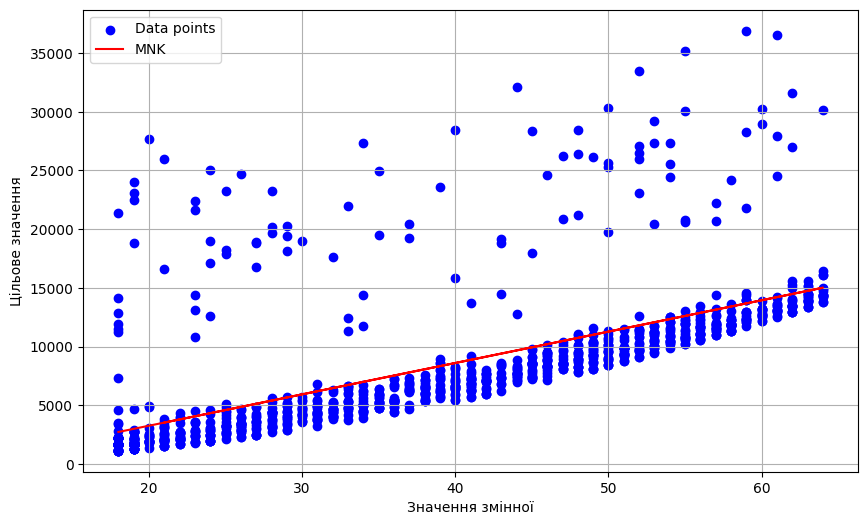

In [198]:
# Візуалізація результатів
plt.figure(figsize=(10, 6))
plt.scatter(X['age'], y, color='blue', label='Data points')
plt.plot(X['age'], predictions_MNK, color='red', label='MNK')
plt.xlabel('Значення змінної')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

In [270]:
r2_mnk = r2_score(y, predictions_MNK)
mse_mnk = mean_squared_error(y, predictions_MNK)  # MSE
rmse_mnk = np.sqrt(mse_mnk)  # RMSE з MSE
mae_mnk = mean_absolute_error(y, predictions_MNK)

print(f"R² score: {r2_1:.2f}")
print(f"Root Mean Squared Error: {rmse_mnk:.2f}")
print(f"Mean Absolute Error: {mae_mnk:.2f}")

R² score: 0.38
Root Mean Squared Error: 4662.51
Mean Absolute Error: 2580.52


In [271]:
print(f"Коефіцієнти моделі: {MNK_coefs}")
print("Прогноз моделі збережений в змінну: predictions_MNK")
print(f"Точність прогнозу RMSE: {rmse_mnk}")

Коефіцієнти моделі: [-2091.42055657   267.24891283]
Прогноз моделі збережений в змінну: predictions_MNK
Точність прогнозу RMSE: 4662.505766636395


# **Full-Batch градієнтний спуск**

In [272]:
# Вибір X (незалежна змінна) і y (цільова змінна)
X = non_smoker_df['age'].to_numpy().reshape(-1, 1)  # двовимірний масив
y = non_smoker_df['charges']  # лишається одновимірним вектором - цільові значення, які мають мати розмір (n,) - відображає одне значення на один рядок даних

In [273]:
type(X), type(y)

(numpy.ndarray, pandas.core.series.Series)

In [274]:
X.shape, y.shape

((1064, 1), (1064,))

In [275]:
# Градієнтний спуск
def full_batch_gradient_descent(X, y, lr=0.01, epochs=100):
    m, b = 0.0, 0.0  # Початкові параметри
    n = len(y)
    errors = []
    for _ in range(epochs):
        y_pred = m * X[:, 0] + b
        error = y_pred - y
        errors.append(sum(error**2))
        m_gradient = (2/n) * np.dot(error, X[:, 0])
        b_gradient = (2/n) * np.sum(error)
        m = m - lr * m_gradient
        b = b - lr * b_gradient
    return m, b, errors

In [276]:
m, b, errors = full_batch_gradient_descent(X, y, lr=0.00001, epochs=1000)
predictions_fbgd = m * X[:, 0] + b

m, b

(220.15455551129122, 0.21300652799863293)

In [277]:
predictions_MNK

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

In [278]:
predictions_fbgd

array([3962.99500573, 6164.54056084, 7265.3133384 , ..., 3962.99500573,
       3962.99500573, 4623.45867227])

In [279]:
m_1, b_1, errors_1 = full_batch_gradient_descent(X, y, lr=0.000001, epochs=10000)
predictions_fbgd_1 = m_1 * X[:, 0] + b_1

m_1, b_1

(220.15455540263423, 0.21301135385474854)

In [280]:
predictions_fbgd_1

array([3962.9950086 , 6164.54056263, 7265.31333964, ..., 3962.9950086 ,
       3962.9950086 , 4623.45867481])

In [281]:
m_2, b_2, errors_2 = full_batch_gradient_descent(X, y, lr=0.0000001, epochs=1000)
predictions_fbgd_2 = m_2 * X[:, 0] + b_2

m_2, b_2

(65.00098750466782, 1.4160432218112806)

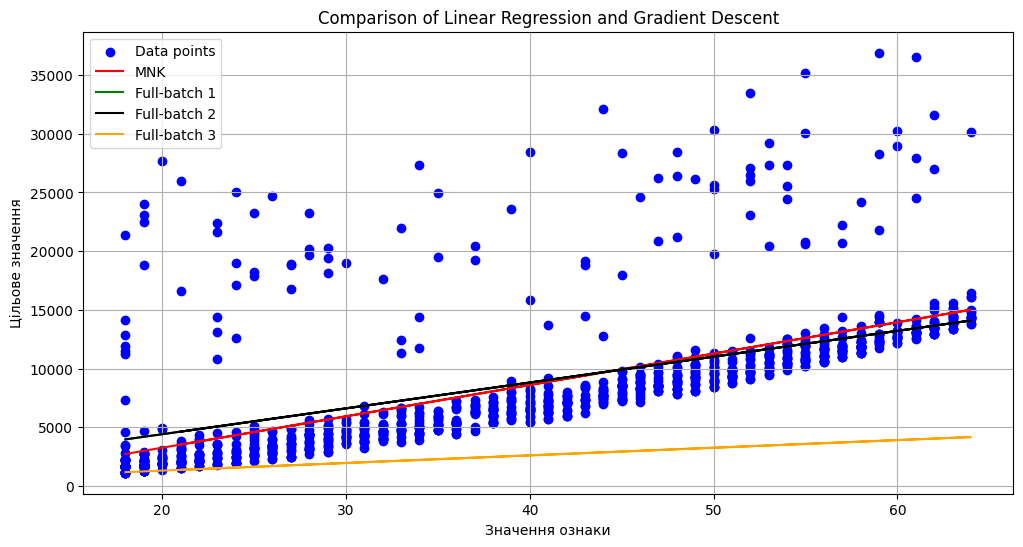

In [282]:
# Візуалізація результатів
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], y, color='blue', label='Data points')
plt.plot(X[:, 0], predictions_MNK, color='red', label='MNK')
plt.plot(X[:, 0], predictions_fbgd, color='green', label='Full-batch 1')
plt.plot(X[:, 0], predictions_fbgd_1, color='black', label='Full-batch 2')
plt.plot(X[:, 0], predictions_fbgd_2, color='orange', label='Full-batch 3')
plt.title('Comparison of Linear Regression and Gradient Descent')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()


In [283]:
r2 = r2_score(y, predictions_fbgd)
mse = mean_squared_error(y, predictions_fbgd)  # MSE
rmse = np.sqrt(mse)  # RMSE з MSE
mae = mean_absolute_error(y, predictions_fbgd)

print(f"R² score | lr=0.00001: {r2:.2f}")
print(f"Root Mean Squared Error | lr=0.00001: {rmse:.2f}")
print(f"Mean Absolute Error | lr=0.00001: {mae:.2f}")

R² score | lr=0.00001: 0.38
Root Mean Squared Error | lr=0.00001: 4715.35
Mean Absolute Error | lr=0.00001: 2809.44


In [284]:
r2_1 = r2_score(y, predictions_fbgd_1)
mse_1 = mean_squared_error(y, predictions_fbgd_1)  # MSE
rmse_1 = np.sqrt(mse_1)  # RMSE з MSE
mae_1 = mean_absolute_error(y, predictions_fbgd_1)

print(f"R² score | lr=0.000001: {r2_1:.2f}")
print(f"Root Mean Squared Error | lr=0.000001: {rmse_1:.2f}")
print(f"Mean Absolute Error | lr=0.000001: {mae_1:.2f}")

R² score | lr=0.000001: 0.38
Root Mean Squared Error | lr=0.000001: 4715.35
Mean Absolute Error | lr=0.000001: 2809.44


In [285]:
r2_2 = r2_score(y, predictions_fbgd_2)
mse_2 = mean_squared_error(y, predictions_fbgd_2)  # MSE
rmse_2 = np.sqrt(mse_2)  # RMSE з MSE
mae_2 = mean_absolute_error(y, predictions_fbgd_2)

print(f"R² score | lr=0.0000001: {r2_2:.2f}")
print(f"Root Mean Squared Error | lr=0.0000001: {rmse_2:.2f}")
print(f"Mean Absolute Error | lr=0.0000001: {mae_2:.2f}")

R² score | lr=0.0000001: -0.79
Root Mean Squared Error | lr=0.0000001: 8020.83
Mean Absolute Error | lr=0.0000001: 5873.35


Модель має не дуже добру апроксимацію (бо треба 0.8 а в нас 0.38). Однак, це не 0 а вже щось. А оскільки MSE чутлива до викидів, а в нас їх багато, то значення R² score не дуже об'єктивне. Думаю треба по можливості уникнути викидів і використати ще інші фактори.

In [286]:
np.mean(y), np.std(y), np.min(y)

(8434.268297856204, 5990.964530287611, 1121.8739)

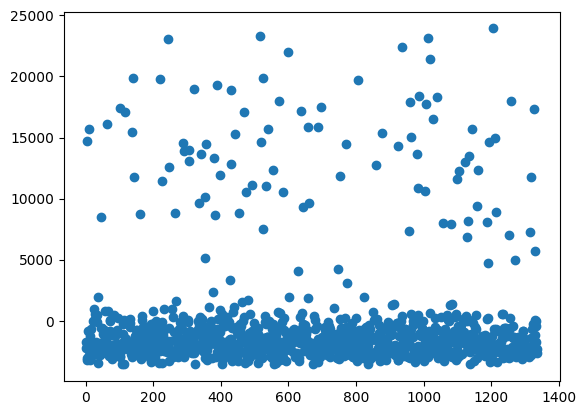

In [293]:
errors = y - predictions_fbgd
plt.plot(errors, 'o');

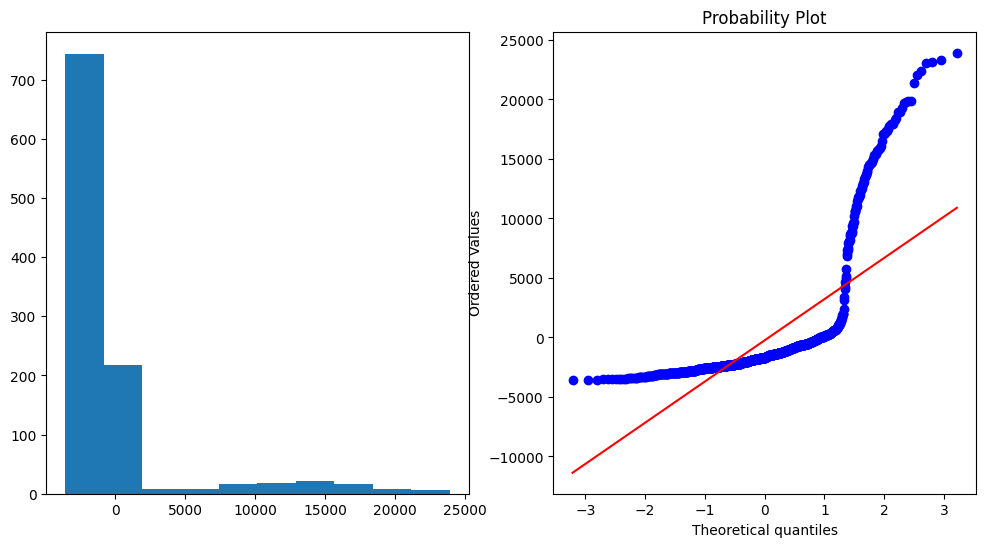

In [294]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(errors)
plt.subplot(1,2,2)
probplot(errors, dist='norm', plot=plt);

Розподіл залишків не виглядає нормальним.

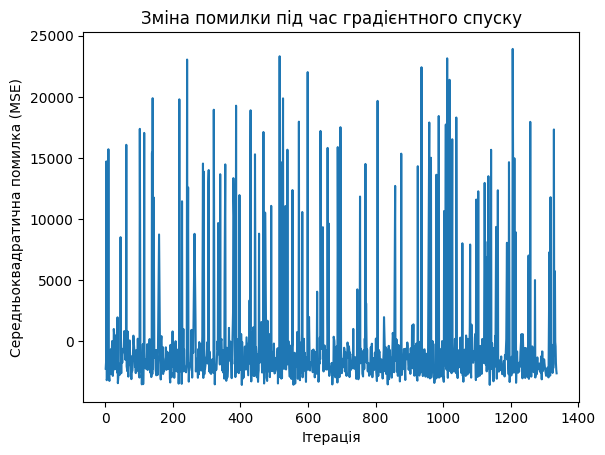

In [295]:
# Графік помилки в залежності від кількості ітерацій
plt.plot(errors)
plt.xlabel('Ітерація')
plt.ylabel('Середньоквадратична помилка (MSE)')
plt.title('Зміна помилки під час градієнтного спуску')
plt.show()

In [300]:
print(f"Коефіцієнти моделі: {(m, b)}")
print("Прогноз моделі збережений в змінну: predictions_fbgd")
print(f"Точність прогнозу RMSE: {rmse}")

Коефіцієнти моделі: (220.15455551129122, 0.21300652799863293)
Прогноз моделі збережений в змінну: predictions_fbgd
Точність прогнозу RMSE: 4715.349750127827


Графік помилок в залежності від ітерації виглядає погано. Однак, з трьох підібраних мною Learning Rate найбільш підходящими є: **0.00001** та **0.000001**. Хоча метод найменших квадратів досі найкращий.

# **scikit-learn.LinearRegression**

In [296]:
# Вибір X (незалежна змінна) і y (цільова змінна)
X = non_smoker_df['age'].to_frame()  # двовимірний масив
y = non_smoker_df['charges']

In [298]:
# Модель лінійної регресії засобами Scikit-learn (МНК)
lin_reg = LinearRegression()

In [299]:
lin_reg.fit(X, y)
lin_reg.coef_, lin_reg.intercept_

(array([267.24891283]), -2091.4205565650864)

In [301]:
predictions_sklearn = lin_reg.predict(X)

In [310]:
r2_lin_reg = r2_score(y, predictions_sklearn)
mse_lin_reg = mean_squared_error(y, predictions_sklearn)  # MSE
rmse_lin_reg = np.sqrt(mse_lin_reg)  # RMSE з MSE
mae_lin_reg = mean_absolute_error(y, predictions_sklearn)

print(f"R² score: {r2_lin_reg:.2f}")
print(f"Root Mean Squared Error: {rmse_lin_reg:.2f}")
print(f"Mean Absolute Error: {mae_lin_reg:.2f}")

R² score: 0.39
Root Mean Squared Error: 4662.51
Mean Absolute Error: 2580.52


In [315]:
print(f"Коефіцієнти моделі: {(lin_reg.intercept_, lin_reg.coef_)}")
print("Прогноз моделі збережений в змінну: predictions_sklearn")
print(f"Точність прогнозу RMSE: {rmse_lin_reg}")

Коефіцієнти моделі: (-2091.4205565650864, array([267.24891283]))
Прогноз моделі збережений в змінну: predictions_sklearn
Точність прогнозу RMSE: 4662.505766636395


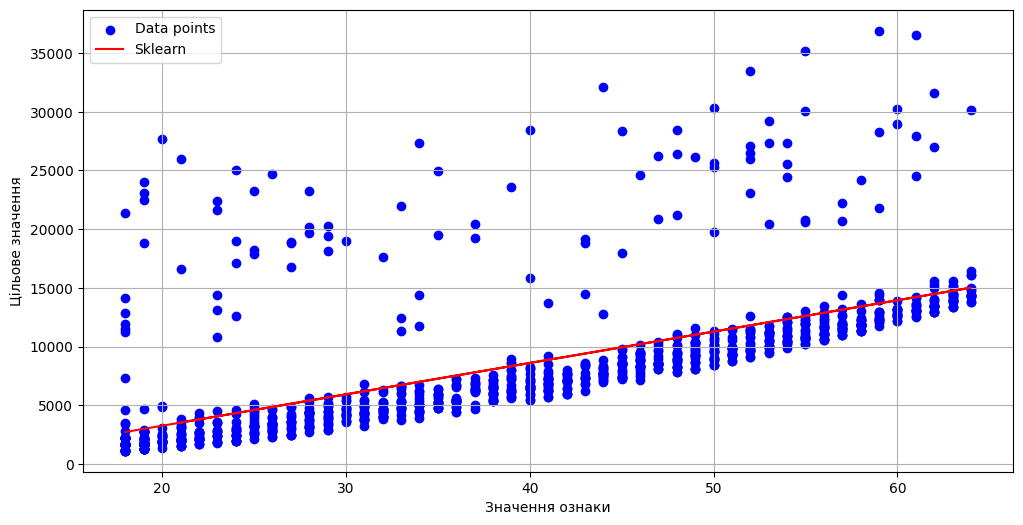

In [312]:
# Візуалізація результатів
plt.figure(figsize=(12, 6))
plt.scatter(X["age"], y, color='blue', label='Data points')
plt.plot(X["age"], predictions_sklearn, color='red', label='Sklearn')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

# ЗАГАЛЬНІ РЕЗУЛЬТАТИ

In [317]:
print("----- MNK -----")
print(f"Коефіцієнти моделі: {MNK_coefs}")
print("Прогноз моделі збережений в змінну: predictions_MNK")
print(f"Точність прогнозу RMSE: {rmse_mnk}")
print()
print("----- Градієнтний спуск -----")
print(f"Коефіцієнти моделі: {(m, b)}")
print("Прогноз моделі збережений в змінну: predictions_fbgd")
print(f"Точність прогнозу RMSE: {rmse}")
print()
print("----- Linear Regression -----")
print(f"Коефіцієнти моделі: {(lin_reg.intercept_, lin_reg.coef_)}")
print("Прогноз моделі збережений в змінну: predictions_sklearn")
print(f"Точність прогнозу RMSE: {rmse_lin_reg}")

----- MNK -----
Коефіцієнти моделі: [-2091.42055657   267.24891283]
Прогноз моделі збережений в змінну: predictions_MNK
Точність прогнозу RMSE: 4662.505766636395

----- Градієнтний спуск -----
Коефіцієнти моделі: (220.15455551129122, 0.21300652799863293)
Прогноз моделі збережений в змінну: predictions_fbgd
Точність прогнозу RMSE: 4715.349750127827

----- Linear Regression -----
Коефіцієнти моделі: (-2091.4205565650864, array([267.24891283]))
Прогноз моделі збережений в змінну: predictions_sklearn
Точність прогнозу RMSE: 4662.505766636395


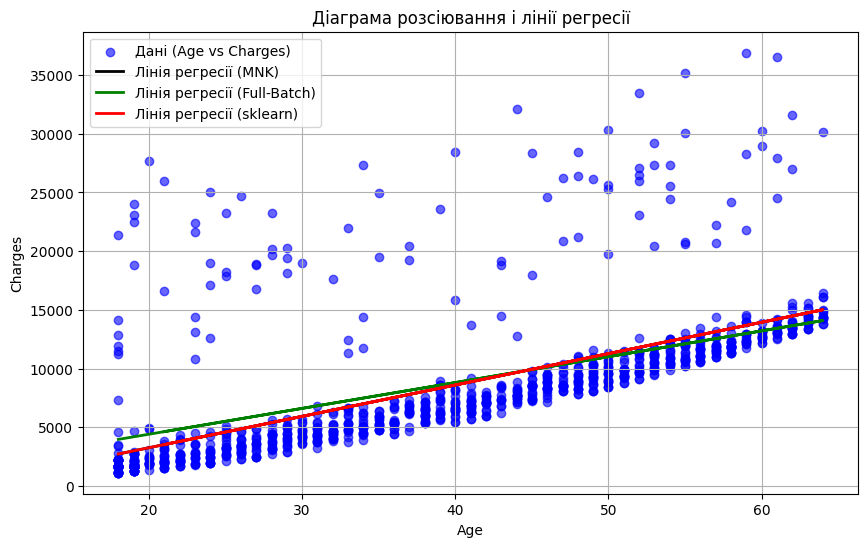

In [318]:
plt.figure(figsize=(10, 6))

# Діаграма розсіювання (age проти charges)
plt.scatter(X["age"], y, color="blue", label="Дані (Age vs Charges)", alpha=0.6)

# Лінія регресії для методу найменших квадратів
plt.plot(X["age"], predictions_MNK, color="black", label="Лінія регресії (MNK)", linewidth=2)

# Лінія регресії для градієнтного спуску
plt.plot(X["age"], predictions_fbgd, color="green", label="Лінія регресії (Full-Batch)", linewidth=2)

# Лінія регресії для sklearn
plt.plot(X["age"], predictions_sklearn, color="red", label="Лінія регресії (sklearn)", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title('Діаграма розсіювання і лінії регресії')
plt.legend()
plt.grid(True)
plt.show()

Отож, як бачимо найкращими виявились MNK та sklearn - вони однакові, адже sklearn використовує MNK.
В одній з попередніх домашок я підібрала такі значення: 290, -3960.2960 (візуально виглядали найкраще) і найкраще значення RMSE яке я досягла - це 4685.4896398113215.
Моделі MNK та sklearn допомогли досягти кращих результатів: 267.24891283, -2091.42055657 та RMSE: 4662.505766636395.
Значення є досить близькими але кращими від моїх найкращих припущень. Тому варто користувватися цими методами.

 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних зборів для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [328]:
smoker_df = medical_df[medical_df.smoker == 'yes']
smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


In [329]:
# Вибір X (незалежна змінна) і y (цільова змінна)
X_smokers = smoker_df['age'].to_frame()  # двовимірний масив
y_smokers = smoker_df['charges']
# Модель лінійної регресії засобами Scikit-learn (МНК)
lin_reg_smokers = LinearRegression()
lin_reg_smokers.fit(X_smokers, y_smokers)
lin_reg_smokers.coef_, lin_reg_smokers.intercept_

(array([305.23760211]), 20294.128126915966)

In [330]:
predictions_sklearn_smokers = lin_reg_smokers.predict(X_smokers)

In [332]:
r2_smokers = r2_score(y_smokers, predictions_sklearn_smokers)
mse_smokers = mean_squared_error(y_smokers, predictions_sklearn_smokers)  # MSE
rmse_smokers = np.sqrt(mse_smokers)  # RMSE з MSE
mae_smokers = mean_absolute_error(y_smokers, predictions_sklearn_smokers)

print(f"R² score: {r2_smokers:.2f}")
print(f"Root Mean Squared Error: {rmse_smokers:.2f}")
print(f"Mean Absolute Error: {mae_smokers:.2f}")
print(f"Коефіцієнти моделі: {(lin_reg_smokers.intercept_, lin_reg_smokers.coef_)}")

R² score: 0.14
Root Mean Squared Error: 10711.00
Mean Absolute Error: 10097.80
Коефіцієнти моделі: (20294.128126915966, array([305.23760211]))


In [337]:
np.mean(y_smokers), np.std(y_smokers), np.min(y_smokers), np.max(y_smokers)

(32050.23183153284, 11520.466706529429, 12829.4551, 63770.42801)

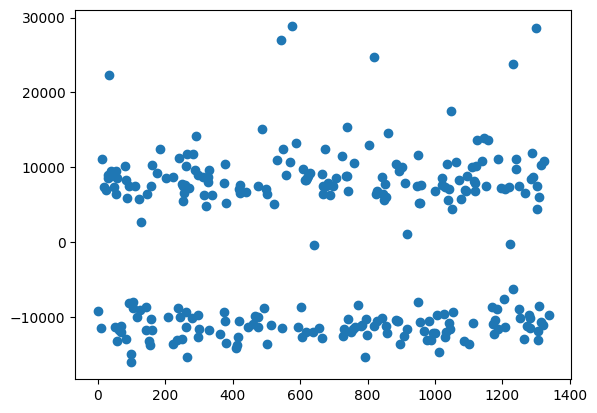

In [334]:
errors = y_smokers - predictions_sklearn_smokers
plt.plot(errors, 'o');

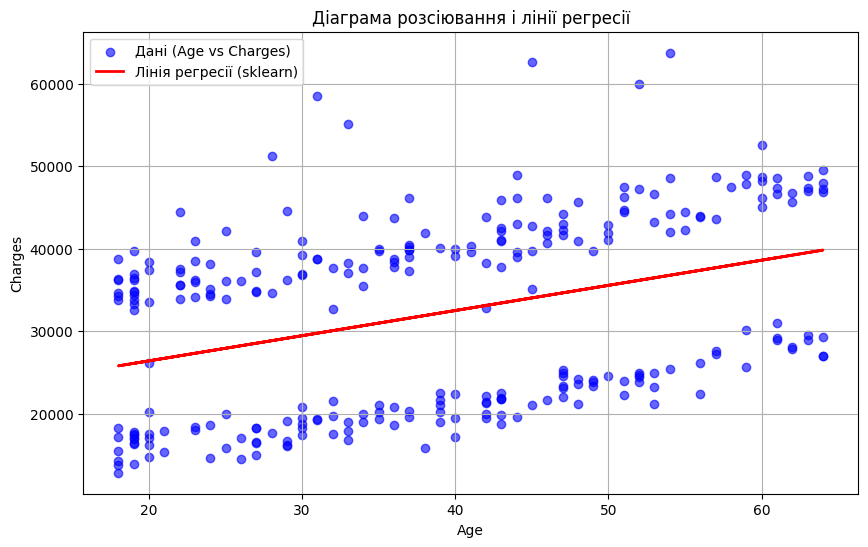

In [335]:
plt.figure(figsize=(10, 6))

# Діаграма розсіювання (age проти charges)
plt.scatter(X_smokers["age"], y_smokers, color="blue", label="Дані (Age vs Charges)", alpha=0.6)

# Лінія регресії для sklearn
plt.plot(X_smokers["age"], predictions_sklearn_smokers, color="red", label="Лінія регресії (sklearn)", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title('Діаграма розсіювання і лінії регресії')
plt.legend()
plt.grid(True)
plt.show()

R² score не нульовий але дуже низький. RMSE навпаки дуже високий. Це й не дивно, адже дані дуже розкидані, щоб за ними можна було побудувати лінійну регресію - помилки великі. Я би розділила дані на дві частини, щоб побудувати дві лінійні регресії. Від 0 до 30000 charges і від 30000 і до кінця. І так дві частини вже прогнозувала б.

In [340]:
smoker_low_charge = smoker_df[smoker_df.charges <= 30000]
smoker_high_charge = smoker_df[smoker_df.charges > 30000]

In [341]:
# Вибір X (незалежна змінна) і y (цільова змінна)
X_low = smoker_low_charge['age'].to_frame()  # двовимірний масив
y_low = smoker_low_charge['charges']
# Модель лінійної регресії засобами Scikit-learn (МНК)
lin_reg_low = LinearRegression()
lin_reg_low.fit(X_low, y_low)

predictions_sklearn_low = lin_reg_low.predict(X_low)

r2_low = r2_score(y_low, predictions_sklearn_low)
mse_low = mean_squared_error(y_low, predictions_sklearn_low)  # MSE
rmse_low = np.sqrt(mse_low)  # RMSE з MSE
mae_low = mean_absolute_error(y_low, predictions_sklearn_low)

print(f"R² score: {r2_low:.2f}")
print(f"Root Mean Squared Error: {rmse_low:.2f}")
print(f"Mean Absolute Error: {mae_low:.2f}")
print(f"Коефіцієнти моделі: {(lin_reg_low.intercept_, lin_reg_low.coef_)}")

R² score: 0.77
Root Mean Squared Error: 1850.55
Mean Absolute Error: 1372.27
Коефіцієнти моделі: (11000.516359750878, array([254.26214196]))


Ось так вже краще, тільки гляньте на R² score = 0.77!

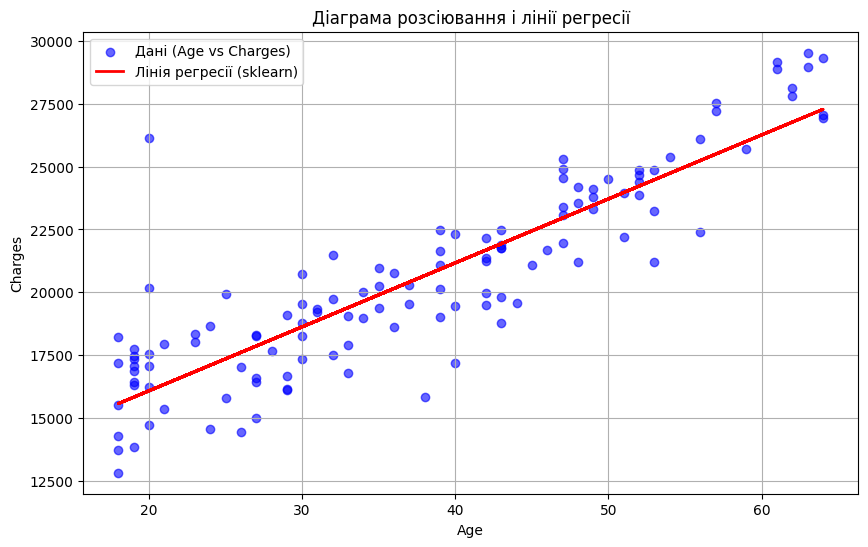

In [343]:
plt.figure(figsize=(10, 6))

# Діаграма розсіювання (age проти charges)
plt.scatter(X_low["age"], y_low, color="blue", label="Дані (Age vs Charges)", alpha=0.6)

# Лінія регресії для sklearn
plt.plot(X_low["age"], predictions_sklearn_low, color="red", label="Лінія регресії (sklearn)", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title('Діаграма розсіювання і лінії регресії')
plt.legend()
plt.grid(True)
plt.show()

In [344]:
# Вибір X (незалежна змінна) і y (цільова змінна)
X_high = smoker_high_charge['age'].to_frame()  # двовимірний масив
y_high = smoker_high_charge['charges']
# Модель лінійної регресії засобами Scikit-learn (МНК)
lin_reg_high = LinearRegression()
lin_reg_high.fit(X_high, y_high)

predictions_sklearn_high = lin_reg_high.predict(X_high)

r2_high = r2_score(y_high, predictions_sklearn_high)
mse_high = mean_squared_error(y_high, predictions_sklearn_high)  # MSE
rmse_high = np.sqrt(mse_high)  # RMSE з MSE
mae_high = mean_absolute_error(y_high, predictions_sklearn_high)

print(f"R² score: {r2_high:.2f}")
print(f"Root Mean Squared Error: {rmse_high:.2f}")
print(f"Mean Absolute Error: {mae_high:.2f}")
print(f"Коефіцієнти моделі: {(lin_reg_high.intercept_, lin_reg_high.coef_)}")

R² score: 0.39
Root Mean Squared Error: 4649.33
Mean Absolute Error: 2849.61
Коефіцієнти моделі: (31080.33509338287, array([259.65789504]))


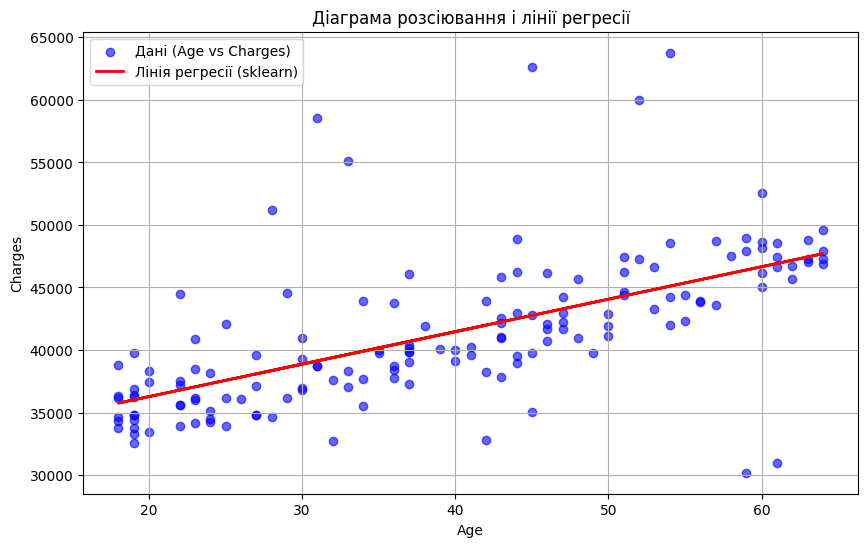

In [345]:
plt.figure(figsize=(10, 6))

# Діаграма розсіювання (age проти charges)
plt.scatter(X_high["age"], y_high, color="blue", label="Дані (Age vs Charges)", alpha=0.6)

# Лінія регресії для sklearn
plt.plot(X_high["age"], predictions_sklearn_high, color="red", label="Лінія регресії (sklearn)", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title('Діаграма розсіювання і лінії регресії')
plt.legend()
plt.grid(True)
plt.show()

Тут вже думаю більше ці викиди впливають. Над якими також можливо попрацювати. Але загалом моя ідея - розділити дані на дві частини.